In [ ]:
!pip install json-tricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from json_tricks import dump, load

In [ ]:
!pip install pydub
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment, effects
import noisereduce as nr

ModuleNotFoundError: ignored

In [ ]:
import tensorflow as tf

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#for taking emotions from TESS database

def from_TESS(fname):
    if 'neutral' in fname : return '01'
    elif 'happy' in fname : return '03'
    elif 'sad' in fname : return '04'
    elif 'angry' in fname : return '05'
    elif 'fear' in fname : return '06'
    elif 'disgust' in fname : return '07'
    elif 'ps' in fname : return '08' # pleasent surprise
    else : return '-1'

In [ ]:
def get_emotion(fname):
    if fname == '01' : return 0 #Neutral
    elif fname == '02' : return 1 #Calm
    elif fname == '03' : return 2 #Happy
    elif fname == '04' : return 3 #Sad
    elif fname == '05' : return 4 #Angry
    elif fname == '06' : return 5 #Fear
    elif fname == '07' : return 6 #Disgust
    elif fname == '08' : return 7 #Pleasent Surprise

In [ ]:
os.getcwd()

In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/My Drive/SER Databases'
os.listdir(folder_path)
for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))
  

In [ ]:
np.max(sample_lengths)

In [ ]:
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 243200 # desired frame length for all of the audio samples./Max of Sample Length
frame_length = 2048
hop_length = 512

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      padded_x = np.pad(xt, (0, abs(total_length-len(xt))), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) 

    # Features extraction 
      feature1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      feature2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      feature3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

    #Extracting Emotion from the files of different Datasets
      if(from_TESS(file) != '-1'):
        ename = from_TESS(file)

      else :
        ename = file[6:8]

    #Appending Extracted features into pre-initiatlised lists
      rms.append(feature1)
      zcr.append(feature2)
      mfcc.append(feature3)
      emotions.append(get_emotion(ename))
      

In [ ]:
#Deleting a row with mismatched size to have the data more in line with each other


del rms[2880]
del zcr[2880]
del mfcc[2880]
del emotions[2880]

In [ ]:
#Converting the list to features to array

feature_rms = np.dstack(rms)
feature_zcr = np.dstack(zcr)
feature_mfcc = np.dstack(mfcc)
target_emotion = np.asarray(emotions, dtype = int)

In [ ]:
#Swapping Values and Cols

feature_rms = np.swapaxes(feature_rms, 0, 2)
feature_zcr = np.swapaxes(feature_zcr, 0, 2)
feature_mfcc = np.swapaxes(feature_mfcc, 0, 2)

In [ ]:
#Concatinating all 3 feature arrays to form a dataframe of sorts for training purpose.

X = np.concatenate((feature_rms, feature_zcr, feature_mfcc), axis = 2)

#Creating target variable y
y = target_emotion
y = np.expand_dims(y, axis = 1)

In [ ]:
# Save X, y arrays as lists to json files.

x_save = X.tolist() 
x_save_path = '/content/drive/My Drive/SER Databases/X_save.json' # FILE SAVE PATH
dump(obj = x_save, fp = x_save_path)

y_save = y.tolist() 
y_save_path = '/content/drive/My Drive/SER Databases/y_save.json' # FILE SAVE PATH
dump(obj = y_save, fp = y_save_path)

In [ ]:
# Load X, y json files back into lists, convert to np.arrays

x_load_path = '/content/drive/My Drive/SER Databases/X_save.json' # FILE LOAD PATH
X_load = load(x_load_path)
X_load = np.asarray(X_load, dtype = 'float32')

y_load_path = '/content/drive/My Drive/SER Databases/y_save.json' # FILE LOAD PATH
y_load = load(y_load_path)
y_load = np.asarray(y_load, dtype = 'int8')

#Creating training, validation and testing data from the complete data variable X.

In [ ]:
X = X_load
y = y_load

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, train_size = 0.8, random_state = 1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, train_size = 0.4, random_state = 1)

In [ ]:
X_valid = np.delete(X_valid, 0, 0)
y_valid = np.delete(y_valid, 0, 0)

In [ ]:
print(np.shape(X_train))
print(np.shape(X_valid))
print(np.shape(X_test))

(4200, 476, 15)
(630, 476, 15)
(420, 476, 15)


One-Hot Vectoring of training and validation target variables

In [ ]:
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_valid_class = tf.keras.utils.to_categorical(y_valid, 8, dtype = 'int8')
y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

**Model Building**

In [ ]:
from keras.models import Sequential, load_model
from keras import layers
from keras import optimizers
from keras import callbacks 
import pickle

#**Model Creation Practice**

In [ ]:
# Model Creation From Scratch

model = Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(476, 15, 1)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

batch_size_scratch = 105

checkpoint_path = '/content/drive/My Drive/SER Databases/Checkpoint_SER/model_ser.hdf5'

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                       monitor='val_categorical_accuracy',
                                       verbose=1, 
                                       save_best_only=True,
                                       mode='max')

model.compile(optimizer='RMSprop',
              loss='CategoricalCrossentropy',
              metrics='CategoricalAccuracy')

history = model.fit(x = X_train,
                    y = y_train_class,
                    batch_size = batch_size_scratch,
                    epochs = 80,
                    validation_data = (X_valid, y_valid_class),
                    callbacks = [checkpoint])

model = load_model(checkpoint_path)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 472, 11, 64)       1664      
                                                                 
 conv2d_9 (Conv2D)           (None, 468, 7, 64)        102464    
                                                                 
 conv2d_10 (Conv2D)          (None, 464, 3, 64)        102464    
                                                                 
 flatten (Flatten)           (None, 89088)             0         
                                                                 
 dense (Dense)               (None, 64)                5701696   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                

In [ ]:
checkpoint_path = '/content/drive/My Drive/SER Databases/Checkpoint_SER/model_ser.hdf5'
model_loaded = load_model(checkpoint_path)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
model_loaded.evaluate(X_valid, y_valid_class)

20/20 [==============================] - 1s 21ms/step - loss: 20.5417 - categorical_accuracy: 0.7683


[20.541662216186523, 0.7682539820671082]

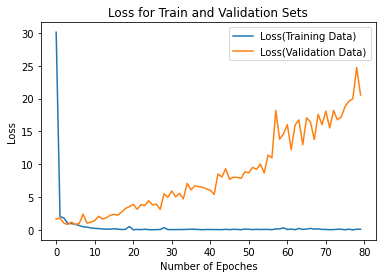

In [ ]:
# Plot for Loss from history

plt.plot(history.history['loss'], label='Loss(Training Data)')
plt.plot(history.history['val_loss'], label='Loss(Validation Data)')
plt.title('Loss for Train and Validation Sets')
plt.ylabel('Loss')
plt.xlabel('Number of Epoches')
plt.legend(loc="best")
plt.show()

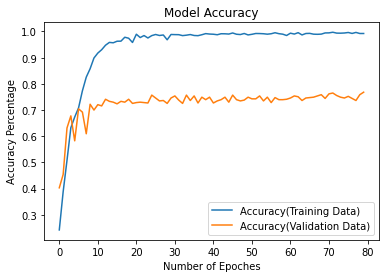

In [ ]:
#Plot for Accuracy from history

plt.plot(history.history['categorical_accuracy'], label='Accuracy(Training Data)')
plt.plot(history.history['val_categorical_accuracy'], label='Accuracy(Validation Data)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy Percentage')
plt.xlabel('Number of Epoches')
plt.legend(loc="best")
plt.show()

20/20 [==============================] - 0s 12ms/step


Text(0.5, 51.0, 'Predicted emotion')

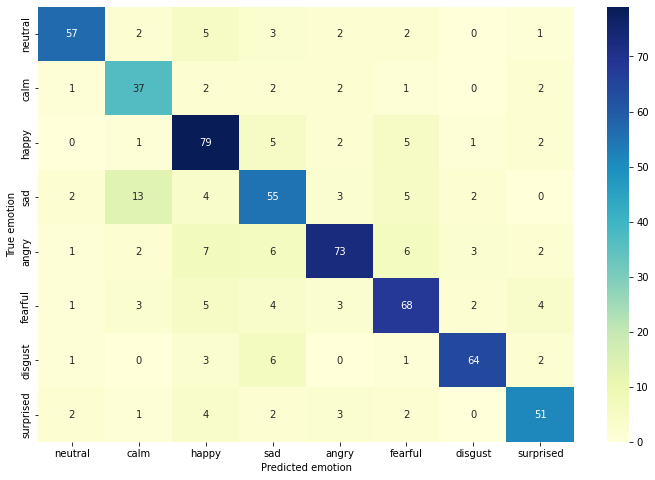

In [ ]:
# Validation Set Confusion Matrix

y_valid_class = np.argmax(y_valid_class, axis=1)
predictions = model_loaded.predict(X_valid)
y_pred_class = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_valid_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                     
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax,cmap='YlGnBu',fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = (values / row_sum)*100

print('Validation set predicted emotions accuracy:')
for i in range(len(values)):
    print("\t"*5,index[i],':', f"{(acc[i]):0.4f}", "%")

Validation set predicted emotions accuracy:
					 neutral : 79.1667 %
					 calm : 72.3404 %
					 happy : 81.0526 %
					 sad : 76.1905 %
					 angry : 82.0000 %
					 fearful : 71.1111 %
					 disgust : 83.1169 %
					 surprised : 81.5385 %


In [ ]:
model_loaded.evaluate(X_test, y_test_class)

14/14 [==============================] - 0s 9ms/step - loss: 12.5935 - categorical_accuracy: 0.7667


[12.59346866607666, 0.7666666507720947]

14/14 [==============================] - 0s 8ms/step


Text(0.5, 51.0, 'Predicted emotion')

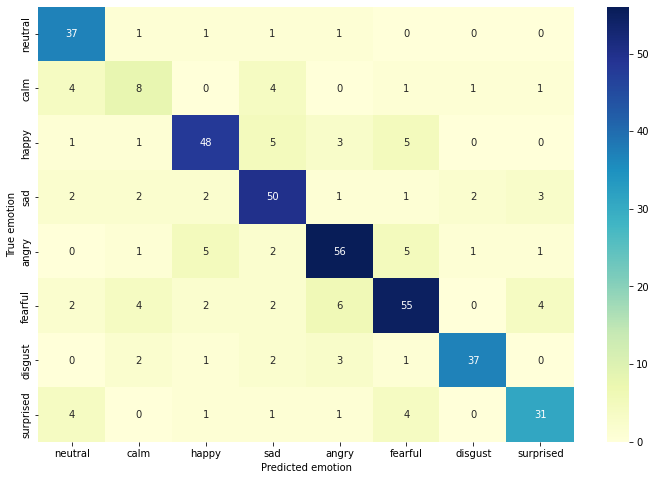

In [ ]:
# Test Set Confusion Matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model_loaded.predict(X_test)
y_pred_class = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                     
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax,cmap='YlGnBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = (values / row_sum)*100

print('Test set predicted emotions accuracy:')
for i in range(len(values)):
    print("\t"*5,index[i],':', f"{(acc[i]):0.4f}", "%")

Test set predicted emotions accuracy:
					 neutral : 90.2439 %
					 calm : 42.1053 %
					 happy : 76.1905 %
					 sad : 79.3651 %
					 angry : 78.8732 %
					 fearful : 73.3333 %
					 disgust : 80.4348 %
					 surprised : 73.8095 %


In [ ]:
model_loaded.summary() # Just for viewing the specifics of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 472, 11, 64)       1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 468, 7, 64)        102464    
                                                                 
 conv2d_2 (Conv2D)           (None, 464, 3, 64)        102464    
                                                                 
 flatten (Flatten)           (None, 89088)             0         
                                                                 
 dense (Dense)               (None, 64)                5701696   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 2